In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
from datetime import datetime, timedelta
# from datetime import datetime as dt, time, timedelta

In [3]:
import sys
from os.path import join
import re

In [4]:
# REMI STUFF
#sys.path.insert(0,'/Users/megret/Documents/Research/BeeTracking/Soft/labelbeeconvert')
#sys.path.insert(0,'/Users/megret/Documents/Research/BeeTracking/Soft/apriltag/swatbotics-apriltag/python/')
#sys.path.insert(0,'/mnt/storage/work/rmegret/labelbeeconvert')
#from labelbeeconvert import labelbee_convert as lb
#from beevideoutil import video as bv
from plotbee.beevideoutil import labelbee_convert as lb
from plotbee.beevideoutil import video as bv

/home/jchan/beepose/plotbee/plotbee/beevideoutil/labelbee_convert.py:277: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from tqdm.notebook import tqdm
# Test
for i in tqdm(range(50)):
    pass

  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
def get_video_date(filename):
    pattern  = r"C(?P<colony>[0-9][0-9])_(?P<year>[0-9][0-9])(?P<month>[0-9][0-9])(?P<day>[0-9][0-9])(?P<hour>[0-9][0-9])(?P<min>[0-9][0-9])(?P<sec>[0-9][0-9])"
    pattern = re.compile(pattern)
    m = pattern.search(filename)
    date_format = ["year", "month", "day", "hour", "min", "sec"]

    YY,MM,DD,hh,mm,ss=[int(m.group(g)) for g in date_format]
    return datetime(2000+YY,MM,DD,hh,mm,ss)

def one_hot_encoding(df, columns=[]):
    cdf = df.copy()
    if isinstance(columns, list):
        for c in columns:
            cdf = one_hot_encode_column(cdf, c)
    elif isinstance(columns, str):
        cdf = one_hot_encode_column(cdf, columns)
    return cdf
  
def one_hot_encode_column(df, column):
    categories = df[column].dropna().unique()
    for cat in categories:
        df[cat] = (df[column] == cat)
    return df

In [7]:
def load_track_df(filename):
    track_df = pd.read_csv(filename)
    starttime = get_video_date(filename)
    track_df["datetime"] = track_df.apply(lambda x: starttime + timedelta(seconds=x["track_startframe"]/20), axis=1)
    track_df["track_starttime"] = track_df.apply(lambda x: starttime + timedelta(seconds=x["track_startframe"]/20), axis=1)
    track_df["track_endtime"] = track_df.apply(lambda x: starttime + timedelta(seconds=x["track_endframe"]/20), axis=1)
    track_df["pollen"] = track_df["track_pollen_score"] > 0.5
    track_df = one_hot_encoding(track_df, columns=["track_event"])
    return track_df

In [8]:
files = glob.glob("/mnt/storage/work/jchan/final_beepose/one_week_data/analysis_tracks*")
files = sorted(files)
track_dfs = list()
for i, file in enumerate(files):
    track_df = load_track_df(file)
    track_df["video_id"] = i
    track_dfs.append(track_df)
    
full_df = pd.concat(track_dfs)

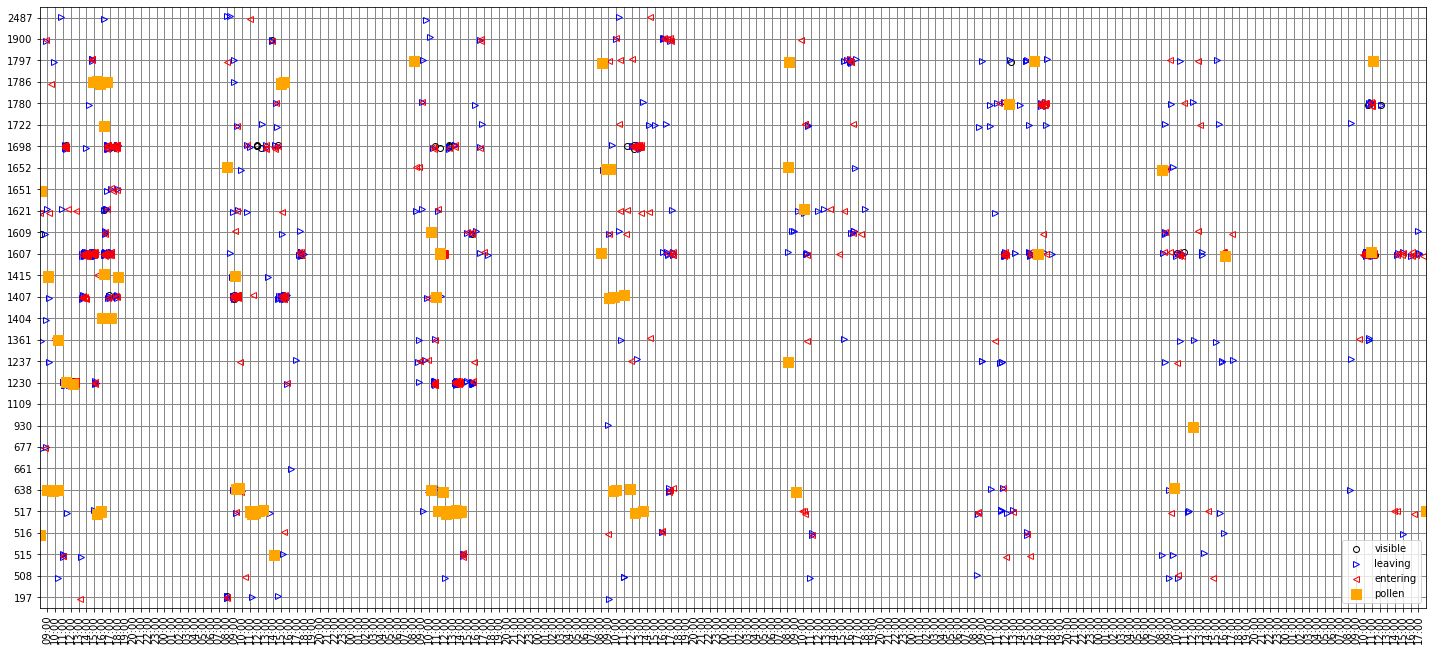

In [9]:
import matplotlib.dates as mdates
from datetime import datetime as dt

vdf = full_df[full_df.groupby('track_tagid').track_tagid.transform('size')>5]

tids = vdf.track_tagid.unique()
tids = np.sort(np.unique(tids)).astype(int)

vdf =full_df[full_df.track_tagid.isin(tids)]

#gdf2=gdf[gdf.tagid.isin([1230,508])]

fig,axes = plt.subplots(1,1,figsize=(20,10))
plt.sca(axes)
lb.plot_activities_df(vdf, plot_interval=True, tagids=tids);
#lb.plot_activities_df(df2, plot_interval=False);
plt.tight_layout();

ax=plt.gca()
hours = mdates.HourLocator() 
hourFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hourFmt)
#ax.set_xlim(dt(2017,6,21,13),dt(2017,6,21,14))
plt.savefig("tagged_bees_activities.png")

In [14]:
from plotbee.video import Video
from collections import defaultdict
import plotbee.videoplotter as vplt

In [16]:
video  = Video.load("/mnt/storage/work/jchan/final_beepose/one_week_data/hungarian_pollen_tags_skeleton_merged_C02_170622110000_fine_new.json")

100%|██████████| 72000/72000 [00:20<00:00, 3484.23it/s]


In [17]:
tagged_bodies = defaultdict(list)
for frame in video:
    for body in frame:
        if body.tag_id is not None:
            tagged_bodies[body.tag_id].append(body)
            

48


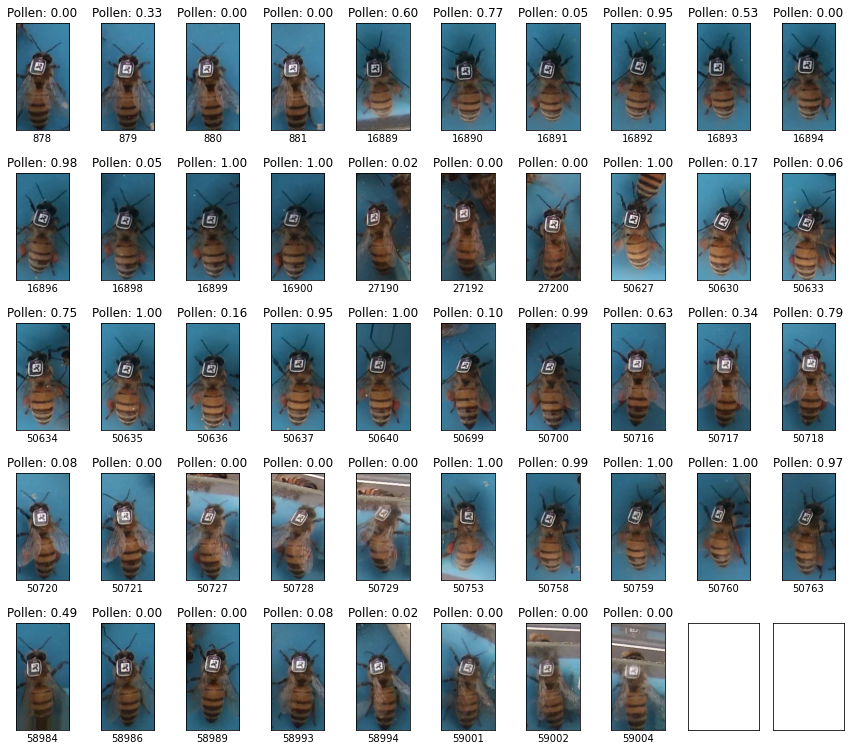

In [18]:
tagid=517
print(len(tagged_bodies[tagid]))
vplt.contact_sheet(tagged_bodies[tagid])